In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import models
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


/Users/kossee/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_annotation_file = 'task2/train_data/annotations.csv'
train_img_labeled_dir = 'images/labeled/'

val_img_dir = 'task2/val_data/'

In [3]:
df = pd.read_csv(train_annotation_file)

In [4]:
df.head()

,renamed_path,label_idx
0,task2/train_data/images/labeled/0.jpeg,0
1,task2/train_data/images/labeled/1.jpeg,0
2,task2/train_data/images/labeled/2.jpeg,0
3,task2/train_data/images/labeled/3.jpeg,0
4,task2/train_data/images/labeled/4.jpeg,0


In [5]:
print("Number of rows in the training dataset: ",df.shape[0])
print("Number of classes: ", df['label_idx'].nunique())
print("Percentage of each class in the training dataset:\n\n",df['label_idx'].value_counts()*100/df.shape[0])

Number of rows in the training dataset:  50000
Number of classes:  100
Percentage of each class in the training dataset:

 label_idx
12    1.984
94    1.836
24    1.778
59    1.768
5     1.720
      ...  
7     0.726
97    0.726
18    0.724
11    0.722
46    0.722
Name: count, Length: 100, dtype: float64


In [6]:
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # le decomentam ptr train
    transforms.RandomRotation(degrees=15), # le decomentam ptr train
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),

])

In [8]:
class AAITDataset(Dataset):
    def __init__(self, dataset, img_dir, is_train=True, transform=None, target_transform=None):
        self.is_train = is_train
        if self.is_train:
            self.img_labels = dataset
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        if self.is_train:
            return len(self.img_labels)
        else:
            self.img_files = [f for f in os.listdir(self.img_dir) if os.path.isfile(os.path.join(self.img_dir, f))]
            return len(self.img_files)

    def __getitem__(self, idx):
        if self.is_train:
            img_path = self.img_labels.iloc[idx, 0]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            #print(image)
            if image.size()[0] == 1:
                image = image.expand(3, -1, -1)
            label = self.img_labels.iloc[idx, 1]
            
            if self.target_transform:
                label = self.target_transform(label)
            return image, label, img_path
        else: 
            img_path = os.path.join(self.img_dir, self.img_files[idx])
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            if image.size(0) == 1:
                image = image.expand(3, -1, -1)
            
            return image, img_path

In [9]:
train_dataset = AAITDataset(train_data, train_img_labeled_dir, is_train=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = AAITDataset(test_data, train_img_labeled_dir, is_train=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


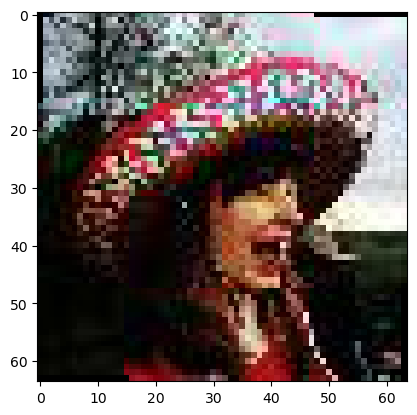

Label: 90


In [10]:
train_features, train_labels, _ = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()
print(f"Label: {label}")

In [11]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    print(mps_device)
else:
    print("MPS not found!")

mps


In [17]:
class CustomModel(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(CustomModel, self).__init__()
        
        self.resnet50 = models.resnet50(weights="IMAGENET1K_V2")

        num_features = self.resnet50.fc.in_features
        self.dropout = nn.Dropout(p=0.1)
        self.resnet50.fc = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.ReLU(),
            self.dropout,
            nn.Linear(1024, num_classes)
        )
        #self.resnet50.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        # Forward pass through the network
        return self.resnet50(x)


model = CustomModel(num_classes=100, pretrained=True).to(mps_device)

In [18]:
def train_model(model, train_dataloader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels, _ in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_dataloader)
        epoch_acc = 100 * correct / total
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, _ in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1

In [19]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

num_classes=100

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model_efficientnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, num_classes)
model_efficientnet = model_efficientnet.to(mps_device)

model_mobilenetv2 = models.mobilenet_v2(pretrained=True)
model_mobilenetv2.classifier[1] = nn.Linear(model_mobilenetv2.last_channel, num_classes)
model_mobilenetv2 = model_mobilenetv2.to(mps_device)

models_ensemble = [model, model_efficientnet, model_mobilenetv2]

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
for i, model in enumerate(models_ensemble):
    print(f"Training model {i+1}/{len(models_ensemble)}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_model(model, train_dataloader, criterion, optimizer, epochs=20, device=mps_device)


Training model 1/3
Epoch 1/20, Loss: 3.9603, Accuracy: 16.26%
Epoch 11/20, Loss: 0.8733, Accuracy: 71.78%
Training model 2/3
Epoch 1/20, Loss: 4.2756, Accuracy: 8.25%
Epoch 11/20, Loss: 1.5906, Accuracy: 54.68%
Training model 3/3
Epoch 1/20, Loss: 3.2602, Accuracy: 22.27%
Epoch 11/20, Loss: 1.3672, Accuracy: 59.26%


In [17]:
def evaluate_ensemble(models, dataloader, criterion, device):
    for model in models:
        model.eval()
    
    total_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, img_paths in dataloader:
            images, labels = images.to(device), labels.to(device)
            ensemble_outputs = torch.zeros(labels.size(0), 100).to(device)
            #print(labels.size(0))
            for model in models:
                outputs = model(images)
                ensemble_outputs += torch.softmax(outputs, dim=1)

            ensemble_outputs /= len(models)
            loss = criterion(ensemble_outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(ensemble_outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
            
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1


In [18]:
avg_loss, acc, prec, rec, f1 = evaluate_ensemble(models_ensemble, test_dataloader, criterion, mps_device)
print("Ensemble Results:")
print("Average loss: ", avg_loss)
print("Accuracy: ", acc*100)
print("Precision: ", prec*100)
print("Recall: ", rec*100)
print("F1 score: ", f1*100)


Ensemble Results:
Average loss:  3.928706428527832
Accuracy:  89.3425
Precision:  89.70210547882589
Recall:  89.3425
F1 score:  89.21616304843306


In [19]:
import pandas as pd
import torch

def generate_pseudo_labels_ensemble(models, dataloader):
    for model in models:
        model.eval()

    pseudo_label_data = []
    with torch.no_grad():
        for images, img_paths in dataloader:
            images = images.to(mps_device)

            ensemble_outputs = torch.zeros(images.size(0), num_classes).to(mps_device)
            for model in models:
                outputs = model(images)
                ensemble_outputs += torch.softmax(outputs, dim=1)
            ensemble_outputs /= len(models)

            _, predicted = torch.max(ensemble_outputs, 1)

            for img_path, label in zip(img_paths, predicted):
                pseudo_label_data.append((img_path, label.item()))

    pseudo_labels_df = pd.DataFrame(pseudo_label_data, columns=['sample', 'label'])
    return pseudo_labels_df


In [20]:
val_unlabeled_dataset = AAITDataset(None, val_img_dir, is_train=False, transform=transform)
val_unlabeled_dataloader = DataLoader(val_unlabeled_dataset, batch_size=64, shuffle=False)

val_labels = generate_pseudo_labels_ensemble(models_ensemble, val_unlabeled_dataloader)
val_labels['sample'] = val_labels['sample'].apply(lambda x: x.split('/')[-1])


In [21]:
val_labels['sort_key'] = val_labels['sample'].str.extract('(\d+)').astype(int)
val_labels.sort_values(by='sort_key', ascending=True, inplace=True)
val_labels.reset_index(inplace=True)
val_labels.drop(columns=['sort_key','index'], inplace=True)

val_labels.to_csv('task2/ensemble.csv', index=False)